In [1]:
%matplotlib inline

import os
import re
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

main_dir = os.getcwd()

%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(style='ticks')

plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
train_files = {
    's2_500k': 's2_worddrop_noanneal_training_iters.txt',
    's3_500k': 's3_worddrop_noanneal_training_iters.txt',
#     's1_anneal_500k': 's1_worddrop_anneal_training_iters.txt',
    's1_500k': 's1_worddrop_noanneal_training_iters.txt',
#     's1_500k': 's1_worddrop_noanneal_training_iters_449k.txt',
    's2_1m': 's2_worddrop_noanneal_1mill_training_iters.txt',
    's3_1m': 's3_worddrop_noanneal_1mill_training_iters.txt',
    's1_anneal_1m': 's1_worddrop_anneal_new_1mill_training_iters.txt',
    's1_1m': 's1_worddrop_noanneal_1mill_training_iters.txt',
#     's1_1m': 's1_worddrop_noanneal_training_iters_600k.txt',
}

In [3]:
replace_dic_val = {'Test set ELBO plus log_p_x = ': '',
              'Test set ELBO = ': '',
              ' (KL = ': ',',
              ') per data point (PP = ': ',',
              ')': ''}

replace_dic = {'Iteration ':'',
              ': ELBO = ': ',',
               ': ELBO plus log_p_x = ': ',',
              ' (KL = ': ',',
              ') per data point (PP = ': ',',
              ') (time taken = ':',',
              ' seconds)': ''}
 
def output_parser_val(model):
    with open(os.path.join(main_dir, train_files[model]), 'r') as f:
        raw_text = f.readlines()
        new_file = ''
        for line in raw_text:
            if re.search('Iteration [0-9]*?', line):
#             if line[:13] == 'Test set ELBO':
#                 elbo = np.float64(re.search('(?<=ELBO = )(-[0-9]+.[0-9]+)', line).group(0))
#                 kl = np.float64(re.search('(?<=KL = )([0-9]+.[0-9]+)', line).group(0))
#                 pp = np.float64(re.search('(?<=PP = )([0-9]+.[0-9]+)', line).group(0))
                
#                 try:
#                     line = np.array_str(elbo) + ',' +  np.array_str(kl) + ',' + np.array_str(pp)
#                 except TypeError:
#                     print(elbo, kl, pp)
#                     print(type(np.array_str(elbo)))
#                     raise
                for i, j in replace_dic.items():
#                     line = np.float64(re.search('(?<=ELBO = )(-[0-9]+.[0-9]+)', line).group(0))
                    line = line.replace(i, j)
                new_file += line


    f = open('output.csv','w')
    f.write(new_file)
    f.close()

    a = pd.read_csv('output.csv', sep=',', header=None, quoting=csv.QUOTE_NONE, encoding='utf-8-sig')
    a.columns = ['a', 'b', 'c', 'd', 'e']
    a.index = a['a']
    a.drop(['a','e'], axis=1, inplace=True)
    #a.columns = ['objective_' + model, 'kl_' + model, 'pp_' + model]
    a.columns = ['objective', 'kl', 'pp']
    if model in ['s2_1m','s3_1m','s1_1m']:  #,'s1_1m']:
        a['iterations'] = 500000 + a.index
#     elif model == 's1_1m':
#         a['iterations'] = a.index #(400 + a.index)
    else:
        a['iterations'] = a.index
    return a

In [4]:
s1_500k = output_parser_val('s1_500k')
s1_1m = output_parser_val('s1_1m')
s1 = pd.concat([s1_500k, s1_1m]).reset_index(drop=True)

# s1_anneal_500k = output_parser_val('s1_anneal_500k')
s1_anneal_1m = output_parser_val('s1_anneal_1m')
s1_anneal = s1_anneal_1m
# s1_anneal = pd.concat([s1_anneal_500k, s1_anneal_1m]).reset_index(drop=True)

s2_500k = output_parser_val('s2_500k')
s2_1m = output_parser_val('s2_1m')
s2 = pd.concat([s2_500k, s2_1m]).reset_index(drop=True)

s3_500k = output_parser_val('s3_500k')
s3_1m = output_parser_val('s3_1m')
s3 = pd.concat([s3_500k, s3_1m]).reset_index(drop=True)


s1['E_log_pxz'] = s1['objective'] + s1['kl']
s1_anneal['E_log_pxz'] = s1_anneal['objective'] + s1_anneal['kl']
s2['E_log_pxz'] = (s2['objective'] + s2['kl'])/2.0
s3['E_log_pxz'] = (s3['objective'] + s3['kl'])/3.0

s1['ELBO'] = s1['E_log_pxz'] - s1['kl']
s1_anneal['ELBO'] = s1_anneal['E_log_pxz'] - s1_anneal['kl']
s2['ELBO'] = s2['E_log_pxz'] - s2['kl']
s3['ELBO'] = s3['E_log_pxz'] - s3['kl']

s1['kl_pct_obj'] = -s1['kl'] / s1['objective']
s1_anneal['kl_pct_obj'] = -s1_anneal['kl'] / s1_anneal['objective']
s2['kl_pct_obj'] = -s2['kl'] / s2['objective']
s3['kl_pct_obj'] = -s3['kl'] / s3['objective']

s1.columns = [col + '_s1' for col in s1.columns]
s1_anneal.columns = [col + '_s1_anneal' for col in s1_anneal.columns]
s2.columns = [col + '_s2' for col in s2.columns]
s3.columns = [col + '_s3' for col in s3.columns]

In [5]:
rolling_avg_no_min = 10
rolling_avg_no_max = 30

def compute_rolling_avg(input_series):
    out_array = np.nan * np.ones_like(input_series.values)
    
    for idx in range(rolling_avg_no_min, len(input_series), 1):
        roll = int(np.around(rolling_avg_no_min + idx/len(input_series) * (rolling_avg_no_max - rolling_avg_no_min)))
        
        out_array[idx] = np.average(input_series[idx-roll:idx])
    
    return out_array
    
results = s1_anneal.set_index('iterations_s1_anneal') \
                    .join(s1.set_index('iterations_s1')) \
                    .join(s2.set_index('iterations_s2')) \
                    .join(s3.set_index('iterations_s3'))

In [6]:
for c in results.columns:
    results[c + '_avg'] = compute_rolling_avg(results[c])
    
results_avg = results[results.index % (1000*rolling_avg_no) == 0]

NameError: name 'rolling_avg_no' is not defined

In [7]:
results_avg = results[results.index % (1000*5) == 0]

In [8]:
rolling_avg_no = 12

results['kl_s1_avg'] = results['kl_s1'].rolling(rolling_avg_no).mean()
results['kl_s1_anneal_avg'] = results['kl_s1_anneal'].rolling(rolling_avg_no).mean()
results['kl_s2_avg'] = results['kl_s2'].rolling(rolling_avg_no).mean()
results['kl_s3_avg'] = results['kl_s3'].rolling(rolling_avg_no).mean()

results['objective_s1_avg'] = results['objective_s1'].rolling(rolling_avg_no).mean()
results['objective_s1_anneal_avg'] = results['objective_s1_anneal'].rolling(rolling_avg_no).mean()
results['objective_s2_avg'] = results['objective_s2'].rolling(rolling_avg_no).mean()
results['objective_s3_avg'] = results['objective_s3'].rolling(rolling_avg_no).mean()

results['E_log_pxz_s1_avg'] = results['E_log_pxz_s1'].rolling(rolling_avg_no).mean()
results['E_log_pxz_s1_anneal_avg'] = results['E_log_pxz_s1_anneal'].rolling(rolling_avg_no).mean()
results['E_log_pxz_s2_avg'] = results['E_log_pxz_s2'].rolling(rolling_avg_no).mean()
results['E_log_pxz_s3_avg'] = results['E_log_pxz_s3'].rolling(rolling_avg_no).mean()

results['ELBO_s1_avg'] = results['ELBO_s1'].rolling(rolling_avg_no).mean()
results['ELBO_s1_anneal_avg'] = results['ELBO_s1_anneal'].rolling(rolling_avg_no).mean()
results['ELBO_s2_avg'] = results['ELBO_s2'].rolling(rolling_avg_no).mean()
results['ELBO_s3_avg'] = results['ELBO_s3'].rolling(rolling_avg_no).mean()

results['kl_pct_obj_s1_avg'] = results['kl_pct_obj_s1'].rolling(rolling_avg_no).mean()
results['kl_pct_obj_s1_anneal_avg'] = results['kl_pct_obj_s1_anneal'].rolling(rolling_avg_no).mean()
results['kl_pct_obj_s2_avg'] = results['kl_pct_obj_s2'].rolling(rolling_avg_no).mean()
results['kl_pct_obj_s3_avg'] = results['kl_pct_obj_s3'].rolling(rolling_avg_no).mean()

results_avg = results[results.index % (1000*rolling_avg_no) == 0]

results.to_csv('results.csv')
# f = open('results.csv','w')
# f.write(results)
# f.close()

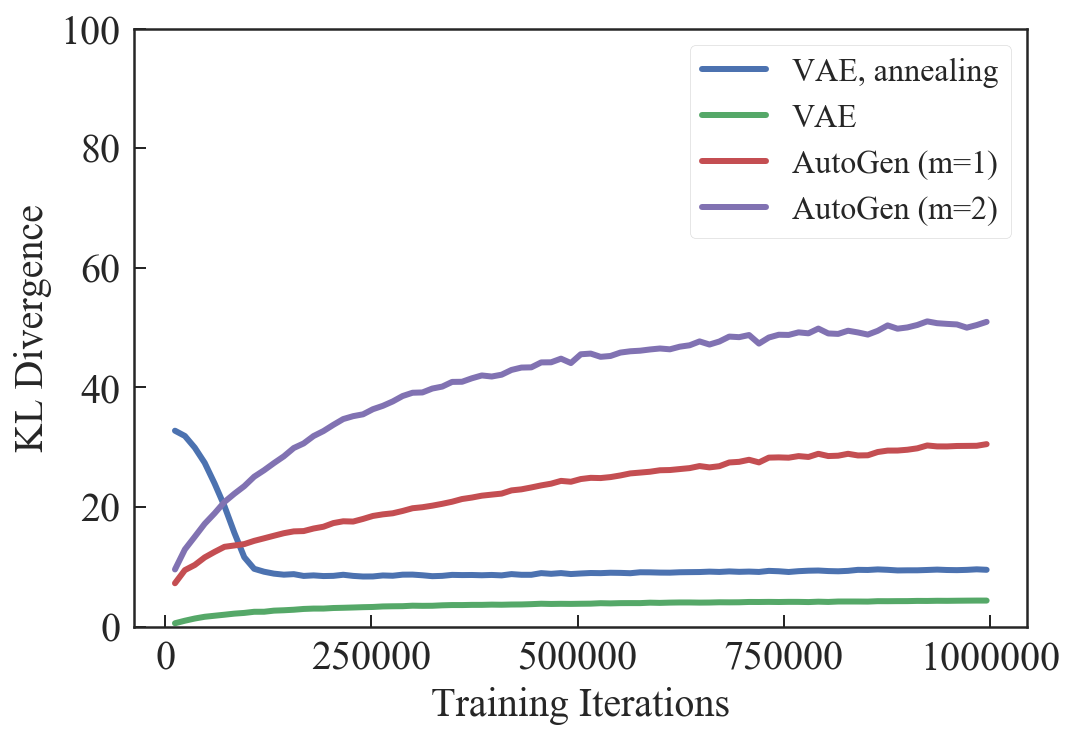

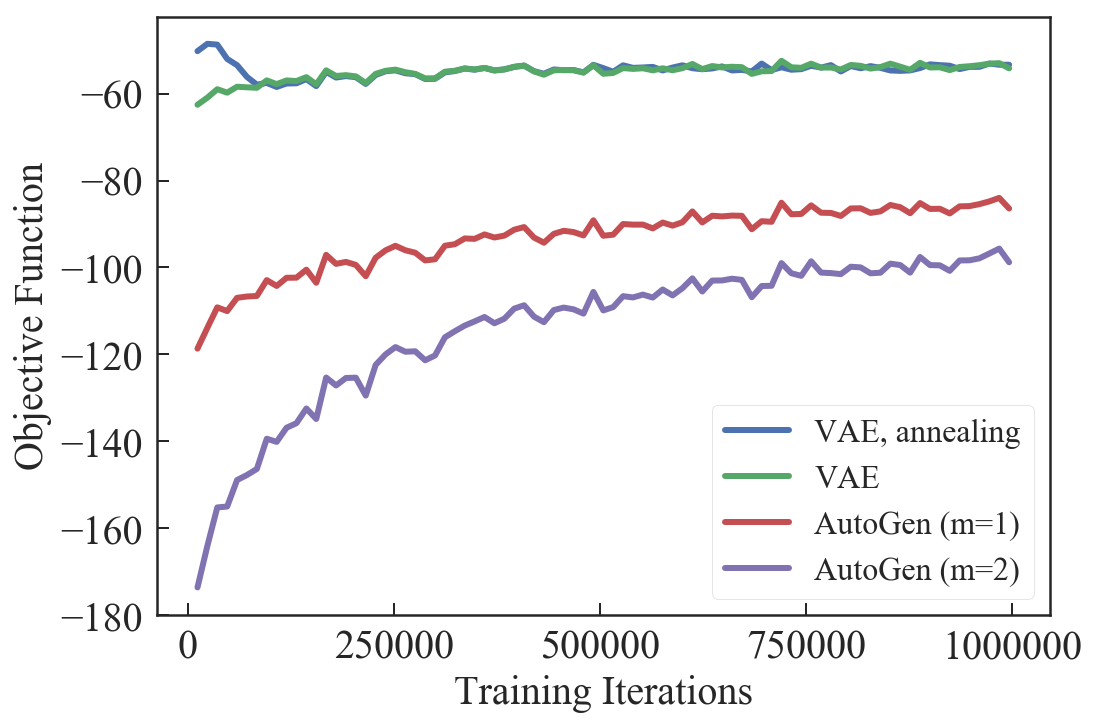

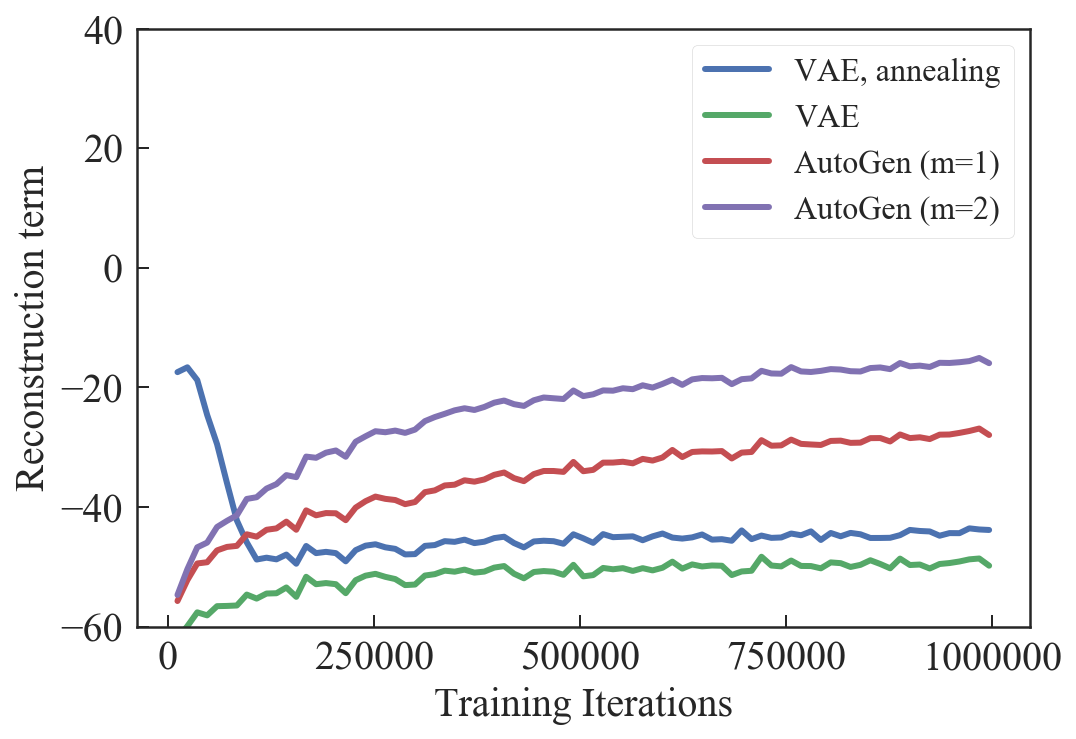

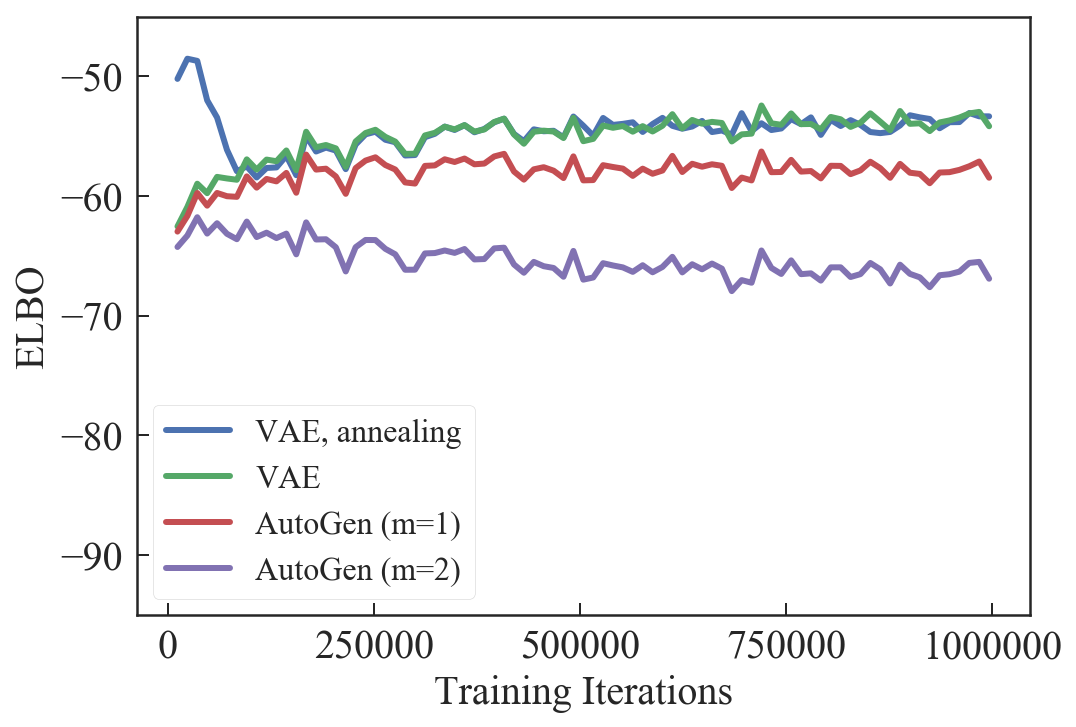

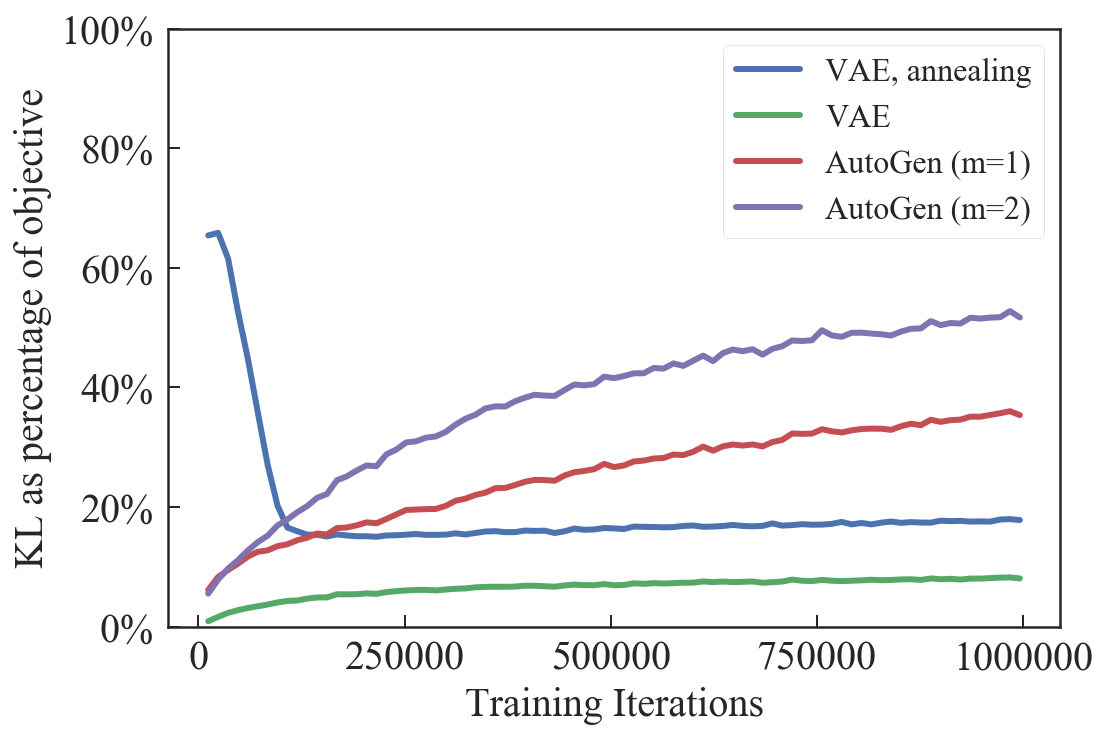

In [9]:
metrics = ['kl', 'objective', 'E_log_pxz', 'ELBO','kl_pct_obj']
ylabels = ['KL Divergence', 'Objective Function',  'Reconstruction term', 'ELBO', 'KL as percentage of objective']


for metric, ylabel in zip(metrics, ylabels):
    
    fig, axs = plt.subplots(nrows=1, ncols=1)
    l1, = plt.plot(results_avg[metric + "_s1_anneal_avg"], label = "VAE, annealing")
    l2, = plt.plot(results_avg[metric + "_s1_avg"], label = "VAE")
    l3, = plt.plot(results_avg[metric + "_s2_avg"], label = "AutoGen (m=1)")
    l4, = plt.plot(results_avg[metric + "_s3_avg"], label = "AutoGen (m=2)")
    
    for l in [l1, l2, l3, l4]:
        plt.setp(l, linewidth=3)
            
    axs.tick_params(direction="in")
    for item in ([axs.title, axs.xaxis.label, axs.yaxis.label] +
                 axs.get_xticklabels() + axs.get_yticklabels()):
        item.set_fontsize(20)
    axs.legend(frameon=True, fontsize=16)
    if ylabel == 'KL Divergence':
        axs.set_ylim(0, 100)
    elif ylabel == 'KL as percentage of objective':
        axs.set_ylim(0, 1)
        axs.set_yticklabels('{:2.0f}%'.format(i*100) for i in axs.get_yticks())
    elif ylabel == 'Reconstruction term':
        axs.set_ylim(-60, 40)
    elif ylabel == 'ELBO':
        axs.set_ylim(-95, -45)
        axs.set_yticks(np.array([-90., -80., -70., -60., -50.]))
        
    start, end = axs.get_xlim()    
    
    axs.set_xticks(np.array([0., 250000., 500000., 750000., 1000000.]))
#     axs.set_xticks(np.arange(start, end+1, 250000))
#     axs.set_xticks(10000 * [0, 250, 500, 750, 100])
#     ax = results_avg.plot(x=results_avg.index.values, y= metric + "_s1_anneal_avg", label = "Standard VAE, with annealing", kind="line")
#     l1, = results_avg.plot(x=results_avg.index.values, y= metric + "_s1_avg", label = "Standard VAE", kind="line", ax=ax)
#     l2, = results_avg.plot(x=results_avg.index.values, y= metric + "_s2_avg", label = "AutoGen (m=2)", kind="line", ax=ax)
#     l3, = results_avg.plot(x=results_avg.index.values, y= metric + "_s3_avg", label = "AutoGen (m=3)", kind="line", ax=ax)
    axs.set_ylabel(ylabel)
    axs.set_xlabel("Training Iterations")
    plt.savefig('learning_curve_' + metric + '.pdf', bbox_inches='tight', dpi=1200)
    plt.show()

In [28]:
print(start, end)
axs.get_xticks()

-18000.0 1038000.0


array([-200000.,       0.,  200000.,  400000.,  600000.,  800000.,
       1000000., 1200000.])

In [122]:
results[['kl_pct_obj_s1_avg','kl_pct_obj_s1_anneal_avg','kl_pct_obj_s2','kl_pct_obj_s3']].tail()

,kl_pct_obj_s1,kl_pct_obj_s1_anneal,kl_pct_obj_s2,kl_pct_obj_s3
iterations_s1_anneal,,,,
995000,0.078735,0.153489,0.363252,0.538051
996000,0.080674,0.154266,0.367457,0.552615
997000,0.086057,0.165685,0.409308,0.619477
998000,0.079589,0.149204,0.359184,0.520487
999000,0.080845,0.154965,0.377893,0.565225


In [26]:
s1_1m.head()

#output_val_s3_worddrop_noanneal = output_parser_val('s3_worddrop_noanneal')
#output_val_s2_worddrop_noanneal = output_parser_val('s2_worddrop_noanneal')
#output_val_s1_worddrop_anneal = output_parser_val('s1_worddrop_anneal')
#output_val_s1_worddrop_noanneal = output_parser_val('s1_worddrop_noanneal')
#
#output_val_s1_worddrop_anneal['E_log_pxz_s1_worddrop_anneal'] = output_val_s1_worddrop_anneal['objective_s1_worddrop_anneal'] + output_val_s1_worddrop_anneal['kl_s1_worddrop_anneal']
#output_val_s1_worddrop_noanneal['E_log_pxz_s1_worddrop_noanneal'] = output_val_s1_worddrop_noanneal['objective_s1_worddrop_noanneal'] + output_val_s1_worddrop_noanneal['kl_s1_worddrop_noanneal']
#output_val_s2_worddrop_noanneal['E_log_pxz_s2_worddrop_noanneal'] = (output_val_s2_worddrop_noanneal['objective_s2_worddrop_noanneal'] + output_val_s2_worddrop_noanneal['kl_s2_worddrop_noanneal'])/2.0
#output_val_s3_worddrop_noanneal['E_log_pxz_s3_worddrop_noanneal'] = (output_val_s3_worddrop_noanneal['objective_s3_worddrop_noanneal'] + output_val_s3_worddrop_noanneal['kl_s3_worddrop_noanneal'])/3.0


,objective,kl,pp,iterations
0,-51.739219,3.838549,46.376730,500000
1,-48.731548,3.790640,40.341714,501000
2,-51.209331,3.795044,47.488369,502000
3,-53.205103,3.817235,47.249507,503000
4,-50.859819,3.872393,46.320385,504000


In [15]:
stanford_val = output_val_s3_worddrop_noanneal.set_index('iterations') \
                    .join(output_val_s2_worddrop_noanneal.set_index('iterations')) \
                    .join(output_val_s1_worddrop_anneal.set_index('iterations')) \
                    .join(output_val_s1_worddrop_noanneal.set_index('iterations'))

stanford_val['kl_s1_worddrop_anneal_avg_val'] = stanford_val['kl_s1_worddrop_anneal'].rolling(5).mean()
stanford_val['kl_s1_worddrop_noanneal_avg_val'] = stanford_val['kl_s1_worddrop_noanneal'].rolling(5).mean()
stanford_val['kl_s2_worddrop_noanneal_avg_val'] = stanford_val['kl_s2_worddrop_noanneal'].rolling(5).mean()
stanford_val['kl_s3_worddrop_noanneal_avg_val'] = stanford_val['kl_s3_worddrop_noanneal'].rolling(5).mean()

stanford_val['objective_s1_worddrop_anneal_avg_val'] = stanford_val['objective_s1_worddrop_anneal'].rolling(5).mean()
stanford_val['objective_s1_worddrop_noanneal_avg_val'] = stanford_val['objective_s1_worddrop_noanneal'].rolling(5).mean()
stanford_val['objective_s2_worddrop_noanneal_avg_val'] = stanford_val['objective_s2_worddrop_noanneal'].rolling(5).mean()
stanford_val['objective_s3_worddrop_noanneal_avg_val'] = stanford_val['objective_s3_worddrop_noanneal'].rolling(5).mean()

stanford_val['E_log_pxz_s1_worddrop_anneal_avg_val'] = stanford_val['E_log_pxz_s1_worddrop_anneal'].rolling(5).mean()
stanford_val['E_log_pxz_s1_worddrop_noanneal_avg_val'] = stanford_val['E_log_pxz_s1_worddrop_noanneal'].rolling(5).mean()
stanford_val['E_log_pxz_s2_worddrop_noanneal_avg_val'] = stanford_val['E_log_pxz_s2_worddrop_noanneal'].rolling(5).mean()
stanford_val['E_log_pxz_s3_worddrop_noanneal_avg_val'] = stanford_val['E_log_pxz_s3_worddrop_noanneal'].rolling(5).mean()

stanford_val['ELBO_original_s1_worddrop_anneal_avg_val'] = stanford_val['E_log_pxz_s1_worddrop_anneal_avg_val'] - stanford_val['kl_s1_worddrop_anneal_avg_val']
stanford_val['ELBO_original_s1_worddrop_noanneal_avg_val'] = stanford_val['E_log_pxz_s1_worddrop_noanneal_avg_val'] - stanford_val['kl_s1_worddrop_noanneal_avg_val']
stanford_val['ELBO_original_s2_worddrop_noanneal_avg_val'] = stanford_val['E_log_pxz_s2_worddrop_noanneal_avg_val'] - stanford_val['kl_s2_worddrop_noanneal_avg_val']
stanford_val['ELBO_original_s3_worddrop_noanneal_avg_val'] = stanford_val['E_log_pxz_s3_worddrop_noanneal_avg_val'] - stanford_val['kl_s3_worddrop_noanneal_avg_val']

stanford_val_100 = stanford_val[stanford_val.index % 5000 == 0]

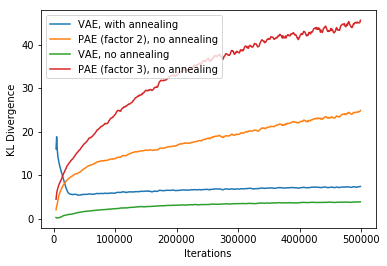

In [20]:
ax = stanford_val.plot(x=stanford_val.index.values, y="kl_s1_worddrop_anneal_avg_val", label = "VAE, with annealing", kind="line")
stanford_val.plot(x=stanford_val.index.values, y="kl_s2_worddrop_noanneal_avg_val", label = "PAE (factor 2), no annealing", kind="line", ax=ax)
stanford_val.plot(x=stanford_val.index.values, y="kl_s1_worddrop_noanneal_avg_val", label = "VAE, no annealing", kind="line", ax=ax)
stanford_val.plot(x=stanford_val.index.values, y="kl_s3_worddrop_noanneal_avg_val", label = "PAE (factor 3), no annealing", kind="line", ax=ax)
ax.set_ylabel("KL Divergence")
ax.set_xlabel("Iterations")
plt.savefig('kl_validation_iters.pdf', bbox_inches='tight')
plt.show()

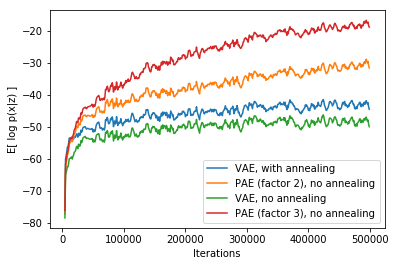

In [21]:
ax = stanford_val.plot(x=stanford_val.index.values, y="E_log_pxz_s1_worddrop_anneal_avg_val", label = "VAE, with annealing", kind="line")
stanford_val.plot(x=stanford_val.index.values, y="E_log_pxz_s2_worddrop_noanneal_avg_val", label = "PAE (factor 2), no annealing", kind="line", ax=ax)
stanford_val.plot(x=stanford_val.index.values, y="E_log_pxz_s1_worddrop_noanneal_avg_val", label = "VAE, no annealing", kind="line", ax=ax)
stanford_val.plot(x=stanford_val.index.values, y="E_log_pxz_s3_worddrop_noanneal_avg_val", label = "PAE (factor 3), no annealing", kind="line", ax=ax)
#ax.set_ylim([0, 50])
ax.set_ylabel("E[ log p(x|z) ]")
ax.set_xlabel("Iterations")
plt.savefig('E_log_pxz_iterations.pdf', bbox_inches='tight')
plt.show()

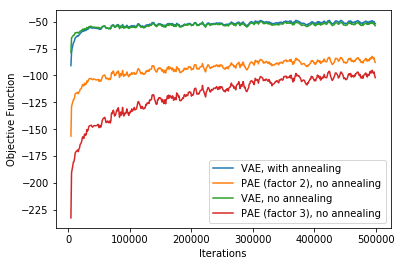

In [22]:
ax = stanford_val.plot(x=stanford_val.index.values, y="objective_s1_worddrop_anneal_avg_val", label = "VAE, with annealing", kind="line")
stanford_val.plot(x=stanford_val.index.values, y="objective_s2_worddrop_noanneal_avg_val", label = "PAE (factor 2), no annealing", kind="line", ax=ax)
stanford_val.plot(x=stanford_val.index.values, y="objective_s1_worddrop_noanneal_avg_val", label = "VAE, no annealing", kind="line", ax=ax)
stanford_val.plot(x=stanford_val.index.values, y="objective_s3_worddrop_noanneal_avg_val", label = "PAE (factor 3), no annealing", kind="line", ax=ax)
ax.set_ylabel("Objective Function")
ax.set_xlabel("Iterations")
plt.savefig('objective_iterations.pdf', bbox_inches='tight')
plt.show()

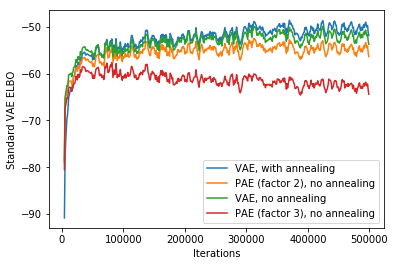

In [23]:
ax = stanford_val.plot(x=stanford_val.index.values, y="ELBO_original_s1_worddrop_anneal_avg_val", label = "VAE, with annealing", kind="line")
stanford_val.plot(x=stanford_val.index.values, y="ELBO_original_s2_worddrop_noanneal_avg_val", label = "PAE (factor 2), no annealing", kind="line", ax=ax)
stanford_val.plot(x=stanford_val.index.values, y="ELBO_original_s1_worddrop_noanneal_avg_val", label = "VAE, no annealing", kind="line", ax=ax)
stanford_val.plot(x=stanford_val.index.values, y="ELBO_original_s3_worddrop_noanneal_avg_val", label = "PAE (factor 3), no annealing", kind="line", ax=ax)
ax.set_ylabel("Standard VAE ELBO")
ax.set_xlabel("Iterations")
plt.savefig('ELBO_original_iterations.pdf', bbox_inches='tight')
plt.show()

In [24]:
a = [1,2,3,4]
b = [1,2,3,5]

In [26]:
not a==b

True